# Check community outliers

In [1]:
# Load communities
commpath = '/data/tumblr_community_identity/dataset114k/louvain_communities.txt'
comms = {}
with open(commpath) as f:
    for i,line in enumerate(f.read().splitlines()):
        comms[i+1] = [int(tumblog_id) for tumblog_id in line.split()]
print(len(comms))

id2comm = {}
for n, comm in comms.items():
    for tumblog_id in comm:
        id2comm[tumblog_id] = n

82


## Plot communities

In [7]:
import plotly.express as px

comm_lens = {str(n): len(ids) for n, ids in comms.items()}
sorted_comms = sorted(comm_lens.items(), key=lambda x: x[1], reverse=True)[:30]
sorted_comms

[('59', 111205),
 ('6', 55514),
 ('49', 43234),
 ('3', 32602),
 ('22', 13910),
 ('11', 13182),
 ('63', 6763),
 ('42', 5072),
 ('10', 4960),
 ('7', 3698),
 ('5', 3485),
 ('2', 2999),
 ('4', 1656),
 ('17', 1508),
 ('15', 804),
 ('71', 287),
 ('1', 266),
 ('32', 265),
 ('20', 54),
 ('23', 32),
 ('67', 19),
 ('27', 17),
 ('51', 15),
 ('14', 12),
 ('19', 12),
 ('24', 11),
 ('25', 8),
 ('28', 6),
 ('54', 6),
 ('26', 5)]

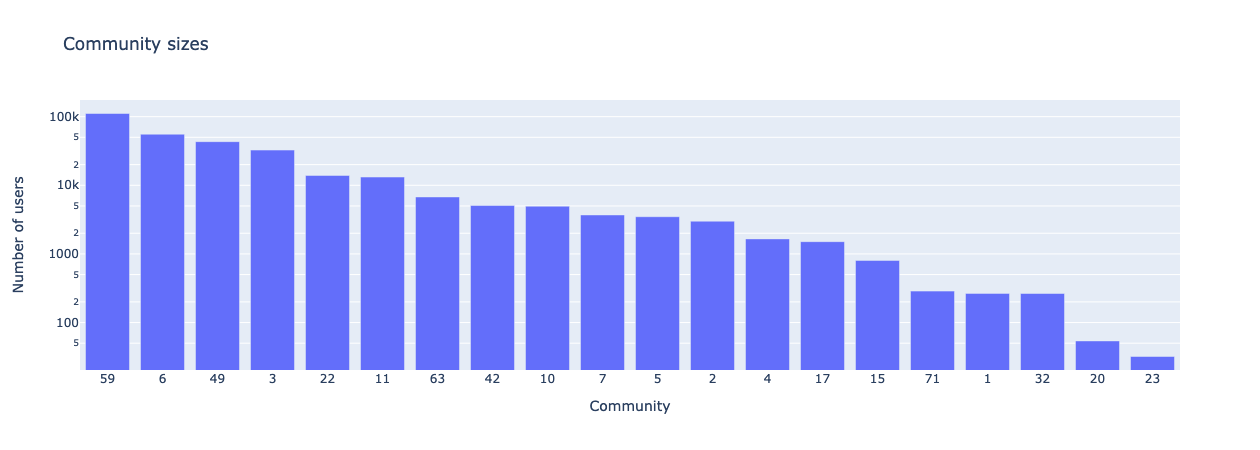

In [13]:
comm_nums, lens = list(zip(*sorted_comms[:20]))
px.bar(x=comm_nums, y=lens, log_y=True, title="Community sizes", labels=dict(x='Community', y='Number of users'))

## Get vectors for blog descriptions
Average word2vec embeddings

In [2]:
# Load blog descriptions
import pandas as pd
desc_path = '/data/tumblr_community_identity/dataset114k/blog_info_dataset114k.csv'
data = pd.read_csv(desc_path)
data

,tumblog_id,tumblr_blog_name,tumblr_blog_url,tumblr_blog_description,processed_tumblr_blog_description,tumblr_blog_title,language,created_time_epoch,is_primary,is_private,updated_time_epoch,post_count,is_group_blog,activity_time_epoch
0,165015715,goteambravo,http://goteambravo.tumblr.com/,<p>Ace/29/female/happily taken by galactic-kni...,ace/29/female/happily taken by galactic-knight...,Go! Go! Bravo!,en_US,1.389199e+12,True,false,1546211412000,NaN,False,1546211412
1,16189626,tomicen,https://tomicen.tumblr.com/,"Amy, 23, Sydney, Australia. ✨ Graphic design a...","amy , 23 , sydney , australia . ✨ graphic desi...",枚方生まれ、枚方育ち,en_US,1.301928e+12,False,false,1546224795000,NaN,False,1562581644
2,15711631,sparkle148,https://sparkle148.tumblr.com/,<p>I post a lot of TMNT and other garbage.</p>,i post a lot of tmnt and other garbage .,Pessimistic Procrastination,en_US,1.301189e+12,False,False,1543078924000.0,31420.0,False,1544982349
3,94232773,goddamnalientourists,http://goddamnalientourists.tumblr.com/,"Name's Lizzie, I'm 20, she/her, a huge sci-fi ...","name 's lizzie , i 'm 20 , she/her , a huge sc...",Sold My Soul To Wynonna Earp,en_US,1.361120e+12,False,false,1530044420000,NaN,False,1543260493
4,3003245,wherethepotterthingsare,https://wherethepotterthingsare.tumblr.com/,"kendra, 22, canada","kendra , 22 , canada",just a face and a name,en_US,1.263865e+12,False,false,1545681604000,NaN,False,1565400429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294248,177356292,ceranimoo,https://ceranimoo.tumblr.com/,<p>ig/anlakbulat</p>,ig/anlakbulat,Anıl,tr_TR,1.395695e+12,False,false,1536688976000,715.0,False,1545951611
294249,27783944,totescrepe,https://totescrepe.tumblr.com/,My name is Kayla and I am a french pancake.,my name is kayla and i am a french pancake .,"Rocks Fall, Everyone Dies",en_US,1.314938e+12,False,False,1545757036000.0,43.0,False,1562464888
294250,381006151,kymsmith,https://kymsmith.tumblr.com/,"This is my everything blog, hope you enjoy it ...","this is my everything blog , hope you enjoy it...",NaN,es_ES,1.512251e+12,False,false,1550947633000,NaN,False,1562703127
294251,402758953,radicallyimpatient,https://radicallyimpatient.tumblr.com/,| Memes | Terf safe | UK | 17 | Janine |,| memes | terf safe | uk | 17 | janine |,"""B i t c h i n""",en_US,1.521362e+12,False,false,1528903149000,NaN,False,1530654530


In [3]:
# Load embeddings
from gensim.models import word2vec

emb_path = '/projects/tumblr_community_identity/websci_exp_20210107/model/post+all_blog_sg_w2v.model'
word_embs = word2vec.Word2Vec.load(emb_path)
word_embs.vector_size

64

In [4]:
# Get embeddings for blog descriptions in communities
import numpy as np
import string

stops = [c for c in string.punctuation]

def word_embeddings(text):
    """ Returns an embedding for a given text, which has
        space-separated tokens. """
    return_arr = np.zeros(64)
    if not isinstance(text, float) and text != '' :
        tokens = text.split()
        embeddings = []
        for word in tokens:
            if word in word_embs.wv and word not in stops:
                embeddings.append(word_embs.wv[word])
        if len(embeddings) > 0:
            return_arr = np.mean(embeddings, axis=0)
    return return_arr

data['community'] = data.tumblog_id.map(id2comm.get)
# data[['tumblog_id', 'community']]

from tqdm.notebook import tqdm

data['desc_emb'] = [word_embeddings(desc) for desc in tqdm(data.processed_tumblr_blog_description)]
data[['tumblog_id', 'desc_emb']]

,tumblog_id,desc_emb
0,165015715,"[-0.061108943, -0.104792595, -0.53758216, -0.0..."
1,16189626,"[-0.11849274, -0.3071503, -0.34691578, 0.01619..."
2,15711631,"[-0.0893156, -0.40070975, -0.24252635, -0.0328..."
3,94232773,"[-0.2271202, -0.16542883, -0.31510505, -0.0066..."
4,3003245,"[-0.09768275, 0.07000937, -0.18964179, 0.47976..."
...,...,...
294248,177356292,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
294249,27783944,"[-0.13581648, -0.29073384, -0.29113567, -0.072..."
294250,381006151,"[-0.074816786, -0.21571168, -0.24323438, -0.18..."
294251,402758953,"[-0.27134824, -0.12634525, -0.33478975, 0.1792..."


## Find community insiders, outliers

In [52]:
# community = 2 # taylor swift
# community = 5 # Arabic, soundcloud, music
# community = 11 # black, ig, twitter
# community = 15 # sims, simblr
community = 59 # art, her
comm_data = data[data['community']==community].copy()
comm_mean = np.mean(np.vstack(comm_data['desc_emb']), axis=0)
print(comm_mean.shape)
comm_mean

import scipy
comm_data['cosine_dist_mean'] = comm_data['desc_emb'].map(lambda x: scipy.spatial.distance.cosine(x, comm_mean))
comm_data['cosine_dist_mean']

# Insiders
pd.set_option('display.max_colwidth', None)
comm_data.sort_values('cosine_dist_mean')[['tumblog_id', 'tumblr_blog_url', 'processed_tumblr_blog_description', 'cosine_dist_mean']].head(30)

(64,)


/projects/tumblr_community_identity/code/conda_env/lib/python3.6/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,tumblog_id,tumblr_blog_url,processed_tumblr_blog_description,cosine_dist_mean
22904,14699422,http://lampfaced.tumblr.com/,"acro // 27 // sex repulsed ace , aromantic spectrum // okapi lamp thing // majored in anthropology , currently a vet tech in training -- ( header art by maunderfiend , icon by me , sidebar art by an artist i ca n't find online anymore who went by kytennish ) - if you need anything tagged , shoot me an ask and i 'll see what i can do ! i try to tag things like gore and body horror but if anything else sticks out , let me know . - what i post/reblog art , zoology , invertebrates , science-y things , queer/social issues , animation , character/creature designs , robots , faceless characters/object heads , monstrous characters fandoms transformers ( tfp/mtmte ) , undertale , steven universe , shane acker 's 9 , hollow knight , ancient magus bride , overwatch , nights , hollow knight - tags i use a n i m a l d r a m a - animal welfare tag that can border on discourse-y at times feel free to ignore - blanket tag for personal posts/posts that i feel are trivial shut up acro - vent/ramble tag acro 's cool tag for attractive people - tag for characters/designs/whatever i find attractive monster love - monster romance tag because i am w e a k for that shit fab art - good art by others tag not my art - art by friends net family - posts pertaining to my friend group , the net family thing for me - art/writing/etc . done for me birb - silly bird tag welcome to jurassic park - birds are dinosaurs tag - important people the bae soul sister science bro - fictional husbando tags xbox husband - genji shimada from overwatch perfect purple husband - shockwave from transformers ( any and all continuities ) campfire husband - grillby from undertale shark husband - sidon from breath of the wild the original cyborg husband - general grievous from star wars jerky boyfriend - hancock from fallout 4 toaster boyfriend - nick valentine from fallout 4 old candycorn bae - jackle from nights into dreams the other robot boyfriend - legion from mass effect salt boyfriend - k-2so from star wars : rogue one",0.012115
189904,372934785,https://askdriftandraptor.tumblr.com/,"( disclaimer ! this is a friendly and non friendly nsfw rp blog , reblog and a sfw rp blog ! you have been warned ! ! ! and if you dont like any of my rebloged sin then leave ! ) hello ! ~ subscribe to my youtube gaming channel ! https : --youtube-com-channel-ucrxxmok1ncyhifd2qjtgz6g got any questions ? ask me and i 'll answer them~ ask box is open ! ! ! i 'm /attack helicopter 😂 jk im male gay age:20 ( ( im not a pedo because that shit is so fucking disgusting ) ) profile picture is not mine and header image is not mine ( dm me if you know who made the artwork and i 'll credit them in this description thanks ! ) x3 ( currently single like a pringle ; - ; xd ) my real name : ethan ( nicknames : sinpai , daddy , or what ever you want to call me lol ) ( i 'm a sinner ) ( i love singing and dancing ) ( birthday : november 28 ) ( it would be nice if someone could message me so i wo n't be lonely ; - ; ) /i support your sexuality and your gender and race i do n't make fun of people 's genders , races or sexualitys/ /do not ask me for a face reveal or ask to see any part of my body ! ! ! and do not ask me for my phone number or where i live ! ! ! ! if you keep begging i will block you thank you very much ^^/ you can send me messages , or fanart ! ) ) ( i love roleplaying about anything related to undertale or anything else /i love drawing and gaming i speak only english i also love memes and undertale too❤ and here 's a long list of my favorite songs enjoy~ ( bad rommance ) ( crazy in love ) ( boss ass bitch ) ( poker face/ /love the way you lie ) ( waterfall ) ( he used to be ) ( swish swish ) ( brave ) ( i will survive ) ( my neck , my back ) ( beez in the trap ) /no one/ ( ( 24k magic ) ) ( ( his theme ) ) ( stronger than you-frisk ) ( stronger than you-sans ) ( survival ) ( 

In [54]:
# Outsiders
outsiders = comm_data[comm_data['processed_tumblr_blog_description'].map(lambda x: len(x) > 10 and 'http' not in x)].sort_values('cosine_dist_mean', ascending=False)[['tumblog_id', 'tumblr_blog_url', 'processed_tumblr_blog_description', 'cosine_dist_mean']].head(40)
outsiders

,tumblog_id,tumblr_blog_url,processed_tumblr_blog_description,cosine_dist_mean
276671,249806173,https://sarcatsticmeme.tumblr.com/,* applause *,0.824552
74506,270713448,http://arteriina.tumblr.com/,oya oya oya,0.793445
104262,137707279,https://antinus-wild.tumblr.com/,marijosé | xix,0.761959
180093,103373763,http://cxnnibalisms.tumblr.com/,indubitably,0.761330
93650,362383641,https://zezir-zalad.tumblr.com/,grub grub grub grub grub grub grub grub grub grub grub grub grub grub grub .,0.744692
66369,212328130,https://brckhmptn4eva.tumblr.com/,•|i|• ø i+ ! ] . [,0.743316
180859,282800966,http://jawsins.tumblr.com/,23menjoy arbys,0.741897
279725,438906078,https://dillonvonpickles.tumblr.com/,serendipity 08|01|16,0.738683
246804,13881872,http://dxlilith.tumblr.com/,"squiggle , squiggle , cross-out",0.729729
144535,73424522,http://finequesadilla.tumblr.com/,rinny / she/her,0.729111


## Sample reblogs from 'unusual' users in their communities

In [6]:
# Load reblog prediction data
reblog_data = pd.read_csv('/data/tumblr_community_identity/dataset114k/matched_reblogs_nonreblogs_dataset114k.csv')
print(reblog_data.columns)
print(reblog_data.shape)

/projects/tumblr_community_identity/code/conda_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,29,38,42,51,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['post_id_reblog', 'activity_time_epoch_reblog', 'activity_date_reblog',
       'post_title_reblog', 'post_short_url_reblog', 'post_slug_reblog',
       'post_type_reblog', 'post_caption_reblog', 'post_format_reblog',
       'post_note_count_reblog', 'reblogged_from_post_id_reblog',
       'created_time_epoch_reblog', 'updated_time_epoch_reblog',
       'source_url_reblog', 'post_id_nonreblog',
       'activity_time_epoch_nonreblog', 'activity_date_nonreblog',
       'post_title_nonreblog', 'post_short_url_nonreblog',
       'post_slug_nonreblog', 'post_type_nonreblog', 'post_caption_nonreblog',
       'post_format_nonreblog', 'post_note_count_nonreblog',
       'reblogged_from_post_id_nonreblog', 'created_time_epoch_nonreblog',
       'updated_time_epoch_nonreblog', 'source_url_nonreblog',
       'tumblog_id_follower_reblog', 'activity_time_epoch_follower_reblog',
       'tumblr_blog_name_follower_reblog', 'tumblr_blog_title_follower_reblog',
       'tumblr_blog_description_foll

In [56]:
# Filter to selected tumblog ids
pd.set_option('display.max_colwidth', None)
# tumblog_id = 191496235
# selected = reblog_data.query('(tumblog_id_follower_reblog == @tumblog_id) | (tumblog_id_followee_reblog == @tumblog_id) |'
#                              '(tumblog_id_followee_nonreblog == @tumblog_id)')
selected = reblog_data[reblog_data['tumblog_id_follower_reblog'].isin(outsiders.tumblog_id)]
selected_cols = []
selected_cols += ['tumblog_id_follower_reblog']
selected_cols += ['processed_tumblr_blog_description_follower_reblog']
for r in ['reblog', 'nonreblog']:
    selected_cols += [f'post_short_url_{r}', f'post_title_{r}']
    selected_cols += [f'processed_tumblr_blog_description_followee_{r}', f'tumblog_id_followee_{r}']
    selected_cols += [f'post_tags_{r}_str']
print(selected_cols)
selected[selected_cols].sample(min(40, len(selected)))

['tumblog_id_follower_reblog', 'processed_tumblr_blog_description_follower_reblog', 'post_short_url_reblog', 'post_title_reblog', 'processed_tumblr_blog_description_followee_reblog', 'tumblog_id_followee_reblog', 'post_tags_reblog_str', 'post_short_url_nonreblog', 'post_title_nonreblog', 'processed_tumblr_blog_description_followee_nonreblog', 'tumblog_id_followee_nonreblog', 'post_tags_nonreblog_str']


,tumblog_id_follower_reblog,processed_tumblr_blog_description_follower_reblog,post_short_url_reblog,post_title_reblog,processed_tumblr_blog_description_followee_reblog,tumblog_id_followee_reblog,post_tags_reblog_str,post_short_url_nonreblog,post_title_nonreblog,processed_tumblr_blog_description_followee_nonreblog,tumblog_id_followee_nonreblog,post_tags_nonreblog_str
19177,438906078,serendipity 08|01|16,https://tmblr.co/ZUHfRY2dzfze8,if I can’t be weird with you then wtf,"i am a mixed race 24 year old transman who has aspergers . yes , you need dysphoria to be trans . nb neutral . i will respect your pronouns . i am taking a break from discourse my nicknames are drunk uncle ( drunkle ) , shark & ninja boy . my reddit is watt_iz_luv . my discord is rhinestone_eyes # 7760",362568325,[],https://tmblr.co/ZymU5b2dzi6y8,NaN,"im shit at bios but uhhh percy jackson , gaming , anime , the emo trinity , youtube , musicals , uhhh im starting to get into marvel mcu",394384640,[]
61075,23521218,aki-kunbara mermangay24male♋fudanshibiologistpro make-up artistbeauty advisor,https://tmblr.co/ZwbDCx2b522cT,NaN,"david , 27 , lisbon - portugal",15757363,[],https://tmblr.co/ZBZ_Cq2b54Wpm,NaN,"weeb in the streets . senpai in the sheets ; ) welcome to my yaoi blog ^^ this is an 18+ blog so please , if you are underage don ’ t follow me~",140761201,[]
6333,274498758,* whooshing noises *,https://tmblr.co/ZsnpEi2dLH8Zt,NaN,reggie-he/him-gay-18-leo-hufflepuff /kinlist,104772877,[],https://tmblr.co/ZPyidi2D2lk-r,NaN,"draws at the speed of maxlad || sfw || updates 2+ pages per week || characterisations in my comics are based on the original ut game , not fanon . ( papyrus tells puns , chara does n't have red eyes )",267973155,"[Underfell, Underfell Sans, Underfell comic, their past]"
57636,359917621,zainab . she/her,https://tmblr.co/Z7az8d2bEuhe1,NaN,monomania is a prerequisite of success,267739538,[],https://tmblr.co/ZhRbIu2bEsJjl,NaN,"river , 24 ⚡️ there is freedom in the dark",72182353,[style]
51340,39372355,... chile/female/aquarius ...,https://tmblr.co/ZvhlFw2d-W2M1,A Big Witchy Guide on Palmistry,"art blog at : dreamteden stephanie/she/17･ . we are made of atoms , yet we can feel so much . is n't it amazing ? * : ・ﾟ✧",138311237,[],https://tmblr.co/ZefJ8y2d-UIZC,NaN,"lulu princess : queen of axolotls , temptress of lawyers , consort to the shaman king , popular sugar daddy , demon of perspective , foster mama , legendarily sweeter than actual sugar , fiercer than fierce , golden retriever worshipper , certified pillow buddy .",7767764,[]
75647,282800966,23menjoy arbys,https://tmblr.co/Zst8lh2bjhZwC,NaN,video games are good,33652638,[],https://tmblr.co/ZI5TKy2bjguVq,NaN,[ and dream when there 's nothing to feast on ] hey im becca i 'm 24 and i like dolls and fashion and disney and achievement hunter and dnd and my ocs and a whole bunch of other stuff i 'm a psychology student studying in jacksonville but one day i 'll become a princess,4583402,[kids are the best]
2665,137707279,marijosé | xix,https://tmblr.co/Z1Mzge2a0s-6M,NaN,"🍇luna.21🏛 be gay , eat more fruit , do crimes",197505938,[],https://tmblr.co/Z4jIXq2a0uhyr,NaN,remy i track # userremy help me survive,135435768,[edited for clarity]
52736,270713448,oya oya oya,https://tmblr.co/ZKxFTi2ZUyjjg,NaN,mostly naruto/carole and tuesday hunterxhunter blog . “ to write a story is to write a person . ”,364487677,[],https://tmblr.co/Zsr7Qn2ZUynNW,NaN,mip | she/her | not spoiler free | multifandoms and other stuff | i also write things,187646918,[]
74788,108433230,ky : they/them,https://tmblr.co/Zk7J8s2ZwcVoP,NaN,pros : • mostly humor • i do n't have enough followers to advertise/promote things . - cons : • none,301555989,[],https://tmblr.co/ZCJ4mq2Zwdoqf,NaN,"madi//19//medically scatterbrained mark ( she/her ) . shitposts , wwe , the arcana game , wow . mhc ‘ 21",131562608,"[WIFE WIFE WIFE, wwe]"
28462,165323130,싸우고 싶어 ? 피나고 싶어 ?,https://tmblr.co/Z2-Hlo2ZYdoi5,NaN,| [ insert passive agressive screm ] | bts 

In [39]:
tumblog_id_cols = [col for col in reblog_data.columns if 'tumblog_id' in col]
tumblog_id_cols

['tumblog_id_follower_reblog',
 'tumblog_id_followee_reblog',
 'tumblog_id_followee_nonreblog']

In [44]:
desc_cols = [col for col in reblog_data.columns if 'blog_description' in col]
desc_cols

['tumblr_blog_description_follower_reblog',
 'tumblr_blog_description_followee_reblog',
 'tumblr_blog_description_followee_nonreblog',
 'processed_tumblr_blog_description_follower_reblog',
 'processed_tumblr_blog_description_followee_reblog',
 'processed_tumblr_blog_description_followee_nonreblog']

In [15]:
tags_cols = [col for col in reblog_data.columns if 'tag' in col]
tags_cols

['post_tags_reblog_str', 'post_tags_nonreblog_str']

# Examine cases where communities don't match 

In [2]:
# Load communities
import pandas as pd

commpath = '/data/tumblr_community_identity/dataset114k/louvain_communities.txt'
comms = {}
with open(commpath) as f:
    for i,line in enumerate(f.read().splitlines()):
        comms[i+1] = [int(tumblog_id) for tumblog_id in line.split()]
print(len(comms))

id2comm = {}
for n, comm in comms.items():
    for tumblog_id in comm:
        id2comm[tumblog_id] = n

# Load reblog prediction data
reblog_data = pd.read_csv('/data/tumblr_community_identity/dataset114k/matched_reblogs_nonreblogs_dataset114k.csv')
print(reblog_data.columns)
print(reblog_data.shape)

# Add community columns
for user in ['follower_reblog', 'followee_reblog', 'followee_nonreblog']:
    reblog_data[f'community_{user}'] = reblog_data[f'tumblog_id_{user}'].map(id2comm.get)

# Investigate NaNs for community
community_cols = [col for col in reblog_data.columns if 'community' in col]
print(len(reblog_data))
reblog_data = reblog_data.dropna(subset=community_cols)
len(reblog_data)

82


/projects/tumblr_community_identity/code/conda_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,29,38,42,51,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['post_id_reblog', 'activity_time_epoch_reblog', 'activity_date_reblog',
       'post_title_reblog', 'post_short_url_reblog', 'post_slug_reblog',
       'post_type_reblog', 'post_caption_reblog', 'post_format_reblog',
       'post_note_count_reblog', 'reblogged_from_post_id_reblog',
       'created_time_epoch_reblog', 'updated_time_epoch_reblog',
       'source_url_reblog', 'post_id_nonreblog',
       'activity_time_epoch_nonreblog', 'activity_date_nonreblog',
       'post_title_nonreblog', 'post_short_url_nonreblog',
       'post_slug_nonreblog', 'post_type_nonreblog', 'post_caption_nonreblog',
       'post_format_nonreblog', 'post_note_count_nonreblog',
       'reblogged_from_post_id_nonreblog', 'created_time_epoch_nonreblog',
       'updated_time_epoch_nonreblog', 'source_url_nonreblog',
       'tumblog_id_follower_reblog', 'activity_time_epoch_follower_reblog',
       'tumblr_blog_name_follower_reblog', 'tumblr_blog_title_follower_reblog',
       'tumblr_blog_description_foll

110898

In [5]:
# Split when communities do and don't match
split_defs = [ # (name, description, query)
    ('all3_match', 'All 3 match',
    'community_follower_reblog == community_followee_reblog == community_followee_nonreblog'),
#     ('followees_dont_match', "Followees don't match",  'community_followee_reblog != community_followee_nonreblog'),
    ('follower_matches_someone', "Followees don't match, but follower matches one", 
     'community_followee_reblog != community_followee_nonreblog and '
                                                '(community_follower_reblog == community_followee_reblog or '
                                                 'community_follower_reblog == community_followee_nonreblog)'),
    ('reblogger_match', 'Reblog followee matches only follower', 'community_follower_reblog == community_followee_reblog '
                                             'and community_follower_reblog != community_followee_nonreblog'),
    ('nonreblogger_match', 'Reblog followee matches only follower', 'community_follower_reblog != community_followee_reblog '
                                             'and community_follower_reblog == community_followee_nonreblog'),
]
splits = {}

for name, desc, query in split_defs:
    splits[name] = reblog_data.query(query)
    print(f'{desc}: {len(splits[name])}, {len(splits[name])/len(reblog_data): .1%} ({len(splits[name])}/{len(reblog_data)})')

# print(f"Followees don't match, but follower matches one: {follower_matches_someone}, {follower_matches_someone/len(reblog_data): .1%} ({follower_matches_someone}/{len(reblog_data)})")

# reblogger_match = len(reblog_data.query('community_follower_reblog == community_followee_reblog'))
# print(f'Reblog followee matches follower: {reblogger_match}, {reblogger_match/len(reblog_data): .1%} ({reblogger_match}/{len(reblog_data)})')

# nonreblogger_match = len(reblog_data.query('community_follower_reblog == community_followee_nonreblog'))
# print(f'Nonreblog followee matches follower: {nonreblogger_match}, {nonreblogger_match/len(reblog_data): .1%} ({nonreblogger_match}/{len(reblog_data)})')

# only_followees_match = len(reblog_data.query('community_follower_reblog != community_followee_reblog '
#                                              'and community_followee_reblog == community_followee_nonreblog'))
# print(f'Only followees match: {only_followees_match}, {only_followees_match/len(reblog_data): .1%} ({only_followees_match}/{len(reblog_data)})')

# no_match = len(reblog_data.query('community_follower_reblog != community_followee_reblog '
#                                              'and community_follower_reblog != community_followee_nonreblog ' 
#                                 'and community_followee_reblog != community_followee_nonreblog'))

All 3 match: 77547,  69.9% (77547/110898)
Followees don't match, but follower matches one: 25787,  23.3% (25787/110898)
Reblog followee matches only follower: 14898,  13.4% (14898/110898)
Reblog followee matches only follower: 10889,  9.8% (10889/110898)


In [9]:
# Test for significant difference between reblog followee matches and nonreblog followee matches
from scipy.stats import chisquare
chisquare([len(splits['reblogger_match']), len(splits['nonreblogger_match'])])

Power_divergenceResult(statistic=623.2629231783457, pvalue=1.459103922739742e-137)

## Look at examples where followees don't match, but follower matches one of them 

In [84]:
selected = reblog_data.query('community_followee_reblog != community_followee_nonreblog and '
                                                '(community_follower_reblog == community_followee_reblog or '
                                                 'community_follower_reblog == community_followee_nonreblog)')
long_descs = (selected.processed_tumblr_blog_description_follower_reblog.map(lambda x: len(x) > 10)) & \
            (selected.processed_tumblr_blog_description_followee_reblog.map(lambda x: len(x) > 10)) & \
            (selected.processed_tumblr_blog_description_followee_nonreblog.map(lambda x: len(x) > 10))
selected = selected[long_descs]

selected_cols = []
selected_cols += ['community_follower_reblog']
selected_cols += ['processed_tumblr_blog_description_follower_reblog']
for r in ['reblog', 'nonreblog']:
    selected_cols += [f'post_short_url_{r}']
    selected_cols += [f'processed_tumblr_blog_description_followee_{r}', f'community_followee_{r}']
    selected_cols += [f'post_title_{r}', f'post_tags_{r}_str']
print(selected_cols)

selected[selected_cols].sample(min(40, len(selected)))

['community_follower_reblog', 'processed_tumblr_blog_description_follower_reblog', 'post_short_url_reblog', 'processed_tumblr_blog_description_followee_reblog', 'community_followee_reblog', 'post_title_reblog', 'post_tags_reblog_str', 'post_short_url_nonreblog', 'processed_tumblr_blog_description_followee_nonreblog', 'community_followee_nonreblog', 'post_title_nonreblog', 'post_tags_nonreblog_str']


,community_follower_reblog,processed_tumblr_blog_description_follower_reblog,post_short_url_reblog,processed_tumblr_blog_description_followee_reblog,community_followee_reblog,post_title_reblog,post_tags_reblog_str,post_short_url_nonreblog,processed_tumblr_blog_description_followee_nonreblog,community_followee_nonreblog,post_title_nonreblog,post_tags_nonreblog_str
69288,59.0,this exists to like/reblog follow at your own risk,https://tmblr.co/Z-Kfvj2ZK7UZ5,quack quack motherflipper moved to lokimorales,22.0,NaN,[],https://tmblr.co/ZIApMt2ZKA6cu,"i 'm pilot ( christina ) ! 22 , bisexual , writer , artist , streamer , nino enthusiast , pokemon lover , pretty much just hanging out . post ml , pokemon and other stuff . ( banner by bechkit )",59.0,NaN,[]
6927,22.0,"| sarah | 24 | u.s. | `` even if i can ’ t be there for you physically , i promise that i will always be here to support and love you as best as i can ''",https://tmblr.co/ZWkFhu2a55o5Z,cassidy | 23 | shawol | isfj-t i just wan na die . profile pic by ashawol,22.0,NaN,[],https://tmblr.co/ZhxUAi2a55btJ,i 'm afraid i must ask for your forgiveness,59.0,a collection of my favourite Shiro expressions,[]
103717,6.0,.... only time enough to expose the heart ....,https://tmblr.co/ZI3XVx2YpREvN,"beautiful images of style , drama & desire , since 2008 . this collection features the work of many talented photographers and lovely models who make their home on tumblr . enjoy . respect the artists . preserve photographer and model credits when reblogging . contains artistic nudity , 18+",49.0,NaN,[],https://tmblr.co/ZhlQ2w2M5Smpa,nyc . lesbian . 26 . biotechnology • astronomy • octopuses • elephants • music • poetry • clone club,6.0,NaN,[]
35181,59.0,i gender identify as joe biden .,https://tmblr.co/Z2zZ7u2bWsKzb,july 12 2015 was the greatest day of my life . that was the day i met as it is . twice .,59.0,NaN,[],https://tmblr.co/ZMLYTx2bWs1IP,"welcome to my blog ! it 's me hannah . 30 , lesbian , lawyer . just trying to make my way through the world . my blog = all the things that make me laugh , sit back and think , or sit up and stare . now to share with you .",6.0,NaN,[]
38078,6.0,all classic hollywood and glam,https://tmblr.co/ZlzH0u2Zrh8T_,"stars of film , music , and literature , among other things which i enjoy . proud american living in canada , born in the '50s and still quite stuck there , tries to be a gentleman !",6.0,NaN,[],https://tmblr.co/Z0k4Os2ZrgUeD,"23 , phlegmatic + sanguine , catholic , tolkien lover , stan of the 9 choirs of holy angels.discerning a call to religious life .",59.0,NaN,[]
31905,59.0,just go with it,https://tmblr.co/Zswlsu2YWJ50y,"amanda 20↑ | multi-fandom | not spoiler free ! 「college student」 soukoku & erasermic . bsd , bnha , ffxii , anime & manga . games , fics , and cute things . i write things from time to time .",59.0,NaN,"[bnha, Dabi]",https://tmblr.co/ZvEy_s2YWGv5i,♡ i 'm andria . i like pink . also @ alutheapple♡ stan astro and theboyz,6.0,NaN,[]
80344,3.0,nsfw . 18+ .,https://tmblr.co/Zu05VZ2ZuYL2C,6 ’ 3 ” 260lbs lightskin || in relationship ❤️🔐😍🌈👈🏽 ( gay ) . this page is just what i like . || fun stuff and freaky things .,3.0,NaN,"[pansexual, follow, hot, otkspanking, gaypornstar]",https://tmblr.co/Zdseal2Zub0ki,"21 year old straight male , i love tits , ass , comics , porn , comedy , movies , anime , bud , and art . this blog can be nsfw sometimes , so only follow if you are 18 years old or older . i take any kind of submissions ( except from guys ) and will answer any questions publicly or privately .",49.0,NaN,[]
98760,59.0,i 'm gay and my lungs do n't work,https://tmblr.co/ZxIL2b2cBRZnB,simon - they/them i like plants and hugs instagram and twitter : plant_5o youtube : simon plant https : --patreon-com-5o,59.0,NaN,[],https://tmblr.co/Zo4u4c2cBPzDV,22🏳️‍🌈canadian insta @ julessbo,6.0,NaN,"[asks, lgbtq]"
6310,10.0,🇹🇷 k o n y a ••arabic translator,https://tmblr.co/ZNyAFj2Z-n6IM,muslima ، sunni ،1985,5.0,‏سوف ترهق قلبك، ولن يحدث إلا ما شاء